In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
import time

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

In [10]:
wind = pd.read_pickle("MergedWindData.pkl")

#chop off the last row and last column to make grid 700*400, this makes slicing the dataframe much easier!
min_range_y =-200
max_range_y =200
min_range_x =-350
max_range_x =350

wind = wind[wind['Points_0']<=max_range_x][wind['Points_0']>min_range_x][wind['Points_2']<=max_range_y][wind['Points_2']>min_range_y]

shape=(len(wind['Points_2'].unique()), len(wind['Points_0'].unique()))
print("wind shape", shape)

C:\Users\James\AppData\Local\Temp\ipykernel_1100\3731104609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind = wind[wind['Points_0']<=max_range_x][wind['Points_0']>min_range_x][wind['Points_2']<=max_range_y][wind['Points_2']>min_range_y]
C:\Users\James\AppData\Local\Temp\ipykernel_1100\3731104609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind = wind[wind['Points_0']<=max_range_x][wind['Points_0']>min_range_x][wind['Points_2']<=max_range_y][wind['Points_2']>min_range_y]


wind shape (400, 700)


In [17]:
size = 60 #20
nu = 1.5E-5
gravity = 9.81

class PINN_NS():
    def __init__(self, loss="MSE"):
        print("\nNew object initializing")
        self.network()

        if loss=="MSE":
          self.loss_func = nn.MSELoss()
          self.loss_pow=2
        else:
          self.loss_func = nn.L1Loss()
          self.loss_pow=1

        self.loss_func = nn.L1Loss()
        self.loss = 0
        self.loss_hist = []
        self.val_hist = []
        self.uvw_loss = 0
        self.fg_loss = 0
        self.epoch=0
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), lr=1.0, max_iter=100, max_eval=None, tolerance_grad=1e-11,
            tolerance_change=1e-9, history_size=100, line_search_fn="strong_wolfe") #history_size=200
        print("\tNew Optimizer Created.")

    def network(self):
        print("New network created")
        self.net = nn.Sequential(
            nn.Linear(4,size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, 4)
        )

    def function(self, x, y, h, angle_diff):

        res = self.net(torch.hstack((x, y, h, angle_diff)))
        u, v, w, p_star = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]

        if self.use_c or self.use_m:
            u_x  = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_y  = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            w_h  = torch.autograd.grad(w, h, grad_outputs=torch.ones_like(w), create_graph=True)[0]

        if self.use_c:
            # add considrartion of continuty (mass conservation equation)
            c = u_x*self.scaling_factors[4]/self.scaling_factors[0] +\
                v_y*self.scaling_factors[5]/self.scaling_factors[1] +\
                w_h*self.scaling_factors[6]/self.scaling_factors[2]
            self.c =100*c

        else:
           self.c = self.null

        if self.use_m:
            # compute the u gradients
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
            u_y  = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
            u_h  = torch.autograd.grad(u, h, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_hh = torch.autograd.grad(u_h, h, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

            # compute the v gradients
            v_x  = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
            v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
            v_h  = torch.autograd.grad(v, h, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_hh = torch.autograd.grad(v_h, h, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

            # compute w gradients
            w_x  = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_xx = torch.autograd.grad(w_x, x, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
            w_y  = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_yy = torch.autograd.grad(w_y, y, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
            w_hh = torch.autograd.grad(w_h, h, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]

            # convert pressure from p* back to p [in SI units]
            # self.scaling_factors[7] scales P_star' to P_star, 1.23 density of air [kg.m^-3]
            # gravity= 9.81 [ms^-2]
            # y*self.scaling_factors[1], height [m]

            p = ((p_star*self.scaling_factors[7]+self.means[7])/1.23-gravity*h/self.scaling_factors[2])

            # compute the modified pressure gradients
            p_x  = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]/self.scaling_factors[0]
            p_y  = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]/self.scaling_factors[1] 
            p_h  = torch.autograd.grad(p, h, grad_outputs=torch.ones_like(p), create_graph=True)[0]/self.scaling_factors[2] 


            #momentume in x, y, h directions. I set u_t =0 since our model is assumed steady-state
            m_x = u * u_x*self.scaling_factors[4]/self.scaling_factors[0] +\
                  v * u_y*self.scaling_factors[4]/self.scaling_factors[1] +\
                  w * u_h*self.scaling_factors[4]/self.scaling_factors[2] +\
                  p_x -\
                  nu * (u_xx*self.scaling_factors[4]/self.scaling_factors[0]**2 +\
                        u_yy*self.scaling_factors[4]/self.scaling_factors[1]**2 +\
                        u_hh*self.scaling_factors[4]/self.scaling_factors[2]**2)

            m_y = u * v_x*self.scaling_factors[5]/self.scaling_factors[0] +\
                  v * v_y*self.scaling_factors[5]/self.scaling_factors[1] +\
                  w * v_h*self.scaling_factors[5]/self.scaling_factors[2] +\
                  p_y-\
                  nu * (v_xx*self.scaling_factors[5]/self.scaling_factors[0] +\
                        v_yy*self.scaling_factors[5]/self.scaling_factors[1] +\
                        v_hh*self.scaling_factors[5]/self.scaling_factors[2])

            m_h = u * w_x*self.scaling_factors[6]/self.scaling_factors[0] +\
                  v * w_y*self.scaling_factors[6]/self.scaling_factors[1] +\
                  w * w_h*self.scaling_factors[6]/self.scaling_factors[2] +\
                  p_h-\
                  nu * (w_xx*self.scaling_factors[6]/self.scaling_factors[0] +\
                        w_yy*self.scaling_factors[6]/self.scaling_factors[1] +\
                        w_hh*self.scaling_factors[6]/self.scaling_factors[2])#- gravity/self.scaling_factors[2]

            self.mx=m_x
            self.my=m_y
            self.mz=m_h
        else:
            self.mx = self.my = self.mz = self.null
        return u, v, w, p_star, self.c, self.mx, self.my, self.mz

    def closure(self):
        self.optimizer.zero_grad()

        u_pred, v_pred, w_pred, p_pred, c_pred, m_x_pred, m_y_pred, m_h_pred = self.function(self.x, self.y, self.h, self.angle_diff)

        if self.use_data:
            u_loss = self.loss_func(u_pred, self.u)*self.scaling_factors[4]**self.loss_pow
            v_loss = self.loss_func(v_pred, self.v)*self.scaling_factors[5]**self.loss_pow
            w_loss = self.loss_func(w_pred, self.w)*self.scaling_factors[6]**self.loss_pow
            self.uvw_loss = u_loss + v_loss + w_loss
            #self.p_loss = 0.1*self.loss_func(p_pred, self.p_star)*self.scaling_factors[7]**self.loss_pow #0.1 is to scale down the importance of p
            self.p_loss = 0
        else:
            self.uvw_loss = 0

        if self.use_m:
            m_x_loss = self.loss_func(m_x_pred, self.null) #do scaling factors need to be included here?
            m_y_loss = self.loss_func(m_y_pred, self.null)
            m_h_loss = self.loss_func(m_h_pred, self.null)
            self.m_loss = 2*(m_x_loss + m_y_loss + m_x_loss)
        else:
            self.m_loss = 0

        if self.use_c:
            self.c_loss = 100*self.loss_func(c_pred, self.null)
        else:
            self.c_loss = 0


        self.loss = self.uvw_loss + self.c_loss + self.m_loss # + self.p_loss ####change this back!

        self.validate()

        self.loss.backward()
        self.epoch += 1
        if not self.epoch%25:
            print('Epoch: {:}, Loss: {:0.6f},\tValidation Loss: {:0.6f}, \tUVW Loss: {:0.6f}, \tP Loss: {:0.6f}, \tC Loss: {:0.6f}, M Loss: {:0.6f}'.format(self.epoch, self.loss, self.val_loss, self.uvw_loss, self.p_loss, self.c_loss,  self.m_loss))

        self.loss_hist.append(self.loss.item())

        return self.loss

    def validate(self):

        res = self.net(torch.hstack((self.val_x, self.val_y, self.val_h, self.val_angle_diff)))
        u_pred, v_pred, w_pred, p_pred = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]

        u_loss = self.loss_func(u_pred, self.val_u)*self.scaling_factors[4]**self.loss_pow
        v_loss = self.loss_func(v_pred, self.val_v)*self.scaling_factors[5]**self.loss_pow
        w_loss = self.loss_func(w_pred, self.val_w)*self.scaling_factors[6]**self.loss_pow
        #p_loss = self.loss_func(p_pred, self.val_p_star)

        self.val_loss = (u_loss + v_loss + w_loss) # + p_loss
        self.val_hist.append(self.val_loss.item())


    def load_training_data(self, X, Y, H, angle_diff, U, V, W, P_star, angles_used):
        print("Loading new training tensors...")

        #Scaling the data
        data = torch.tensor(np.hstack((X, Y, H, angle_diff, U, V, W, P_star)), dtype=torch.float32)
        print("data.shape", data.shape)
        self.means = data.mean(dim=0)
        print("data.mean(dim=0)", data.mean(dim=0),"data.mean(dim=-1)", data.mean(dim=-1))
        self.stdvs = data.std(dim=0)
        #self.scaling_factors = self.stdvs/3.0

        self.scaling_factors =torch.tensor(np.array((32,16,1,1,32,50,30,200)), dtype=torch.float32)

        print("data shapes\tdata.shape:", data.shape, "means", self.means, "scaling factors", self.scaling_factors)
        data = (data - self.means)/self.scaling_factors


        #Saving the scaled data
        self.x, self.y, self.h, self.angle_diff, self.u, self.v, self.w, self.p_star = torch.split(data, 1, dim=1)
        self.x.requires_grad_()
        self.y.requires_grad_()
        self.h.requires_grad_()

        self.deg = angles_used
        self.null = torch.zeros((self.x.shape[0], 1))
        print("New training tensors Loaded!\n")

    def load_validaiton_data(self, X, Y, H, angle_diff, U, V, W, P_star, angles_used):
        print("Loading new validation tensors...")
        data = torch.tensor(np.hstack((X, Y, H, angle_diff, U, V, W, P_star)), dtype=torch.float32)
        data = (data - self.means)/self.scaling_factors

        #Saving the scaled data
        self.val_x, self.val_y, self.val_h, self.val_angle_diff, self.val_u, self.val_v, self.val_w, self.val_p_star = torch.split(data, 1, dim=1)
        self.val_deg = angles_used
        self.val_null = torch.zeros((self.val_x.shape[0], 1))
        self.val_loss =0
        print("New validation tensors Loaded!\n")

    def predict(self, x, y, h, angle_diff, shape=shape):
        data = torch.tensor(np.hstack((x, y, h, angle_diff)), dtype=torch.float32)
        data = (data - self.means[:4])/self.scaling_factors[:4]

        res = self.net(data)
        u, v, w, p_star = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]

        u = u*self.scaling_factors[4]+self.means[4]
        v = v*self.scaling_factors[5]+self.means[5]
        w = w*self.scaling_factors[6]+self.means[6]
        p = p_star*self.scaling_factors[7]+self.means[7]

        return tuple([i.data.cpu().numpy().reshape(shape) for i in [u, v, w, p]])


    def train(self, epochs=100, use_c=True,use_m=True, use_data=True, lr=1.0):
        print("Beginning Training..")
        start_time = time.time()
        self.use_c = use_c
        self.use_m = use_m
        self.use_data = use_data
        for group in self.optimizer.param_groups:
          group['max_iter']=epochs
          group['max_eval']=epochs
          group['lr']=lr

        print("Traing:\tUse Data=", self.use_data,
              "Traing:\tUse Momentum Eqs=", self.use_m,
              "\tUse Mass Conservation=", self.use_c,
              "\tEpochs = ", self.optimizer.param_groups[0]['max_iter'],
              "\tLearning Rate = ", self.optimizer.param_groups[0]['lr'],)
        print("\tTraining angles = ",self.deg, "\tValidation angles =", self.val_deg)

        self.net.train()
        self.optimizer.step(self.closure)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nTraining complete.\tElapsed time: {int(elapsed_time)} seconds")


    def get_lost(self):
        return self.loss_hist, self.val_hist

In [18]:
def get_preprocessed_data(w_indicies, get_pressure=False):

    angles_to_match = list(map(lambda x: 10*x-70, w_indicies)) #index 7 = 0 degrees angle
    print("Getting preprocessed data for angles", angles_to_match, "\N{DEGREE SIGN}")
    selected_wind = wind[np.isin(wind['angle'], angles_to_match)]

    #Extracting data from dataframe
    Points_0 = selected_wind['Points_0'].to_numpy() #X
    Points_1 = selected_wind['Points_1'].to_numpy() #H
    Points_2 = selected_wind['Points_2'].to_numpy() #Y

    U_0 = selected_wind['U_0'].to_numpy() #U
    U_1 = selected_wind['U_1'].to_numpy() #W
    U_2 = selected_wind['U_2'].to_numpy() #V

    angle_diff = selected_wind['inlet_wind_normal_surf_diff'].to_numpy()


    pressure = selected_wind['p'].to_numpy()
    preprocessed = (Points_0, Points_2, Points_1, angle_diff, U_0, U_2, U_1, pressure)

    return tuple([item.reshape(-1,1) for item in preprocessed])+ (angles_to_match,)

In [19]:
PINN = PINN_NS(loss="L1") #create a new Model, loss="MSE"
*preprocessed_data, angles = get_preprocessed_data([7]) #angle 7 = 0 deg, change to 7,8,9 for -10,0,10 etc.
PINN.load_training_data(*(i.reshape((400,700, len(angles)))[::7,::7].reshape(-1,1) for i in preprocessed_data), angles)
PINN.load_validaiton_data(*(i[::13] for i in get_preprocessed_data([7])))
PINN.train(use_c=False, use_m=True, use_data=True, lr=0.7, epochs=500)


New object initializing
New network created
	New Optimizer Created.
Getting preprocessed data for angles [0] °
Loading new training tensors...
data.shape torch.Size([5800, 8])
data.mean(dim=0) tensor([-2.5000e+00,  5.0000e-01, -4.3708e+01,  1.3333e-02,  1.5405e+01,
        -1.5487e+00,  3.8773e-01,  3.6795e+00], device='cuda:0') data.mean(dim=-1) tensor([-68.6627, -68.0005, -67.2773,  ...,  64.4323,  65.4661,  66.6790],
       device='cuda:0')
data shapes	data.shape: torch.Size([5800, 8]) means tensor([-2.5000e+00,  5.0000e-01, -4.3708e+01,  1.3333e-02,  1.5405e+01,
        -1.5487e+00,  3.8773e-01,  3.6795e+00], device='cuda:0') scaling factors tensor([ 32.,  16.,   1.,   1.,  32.,  50.,  30., 200.], device='cuda:0')
New training tensors Loaded!

Getting preprocessed data for angles [0] °
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
Traing:	Use Data= True Traing:	Use Momentum Eqs= True 	Use Mass Conservation= False 	Epochs =  500 	Learning Ra

Getting preprocessed data for angles [0] °


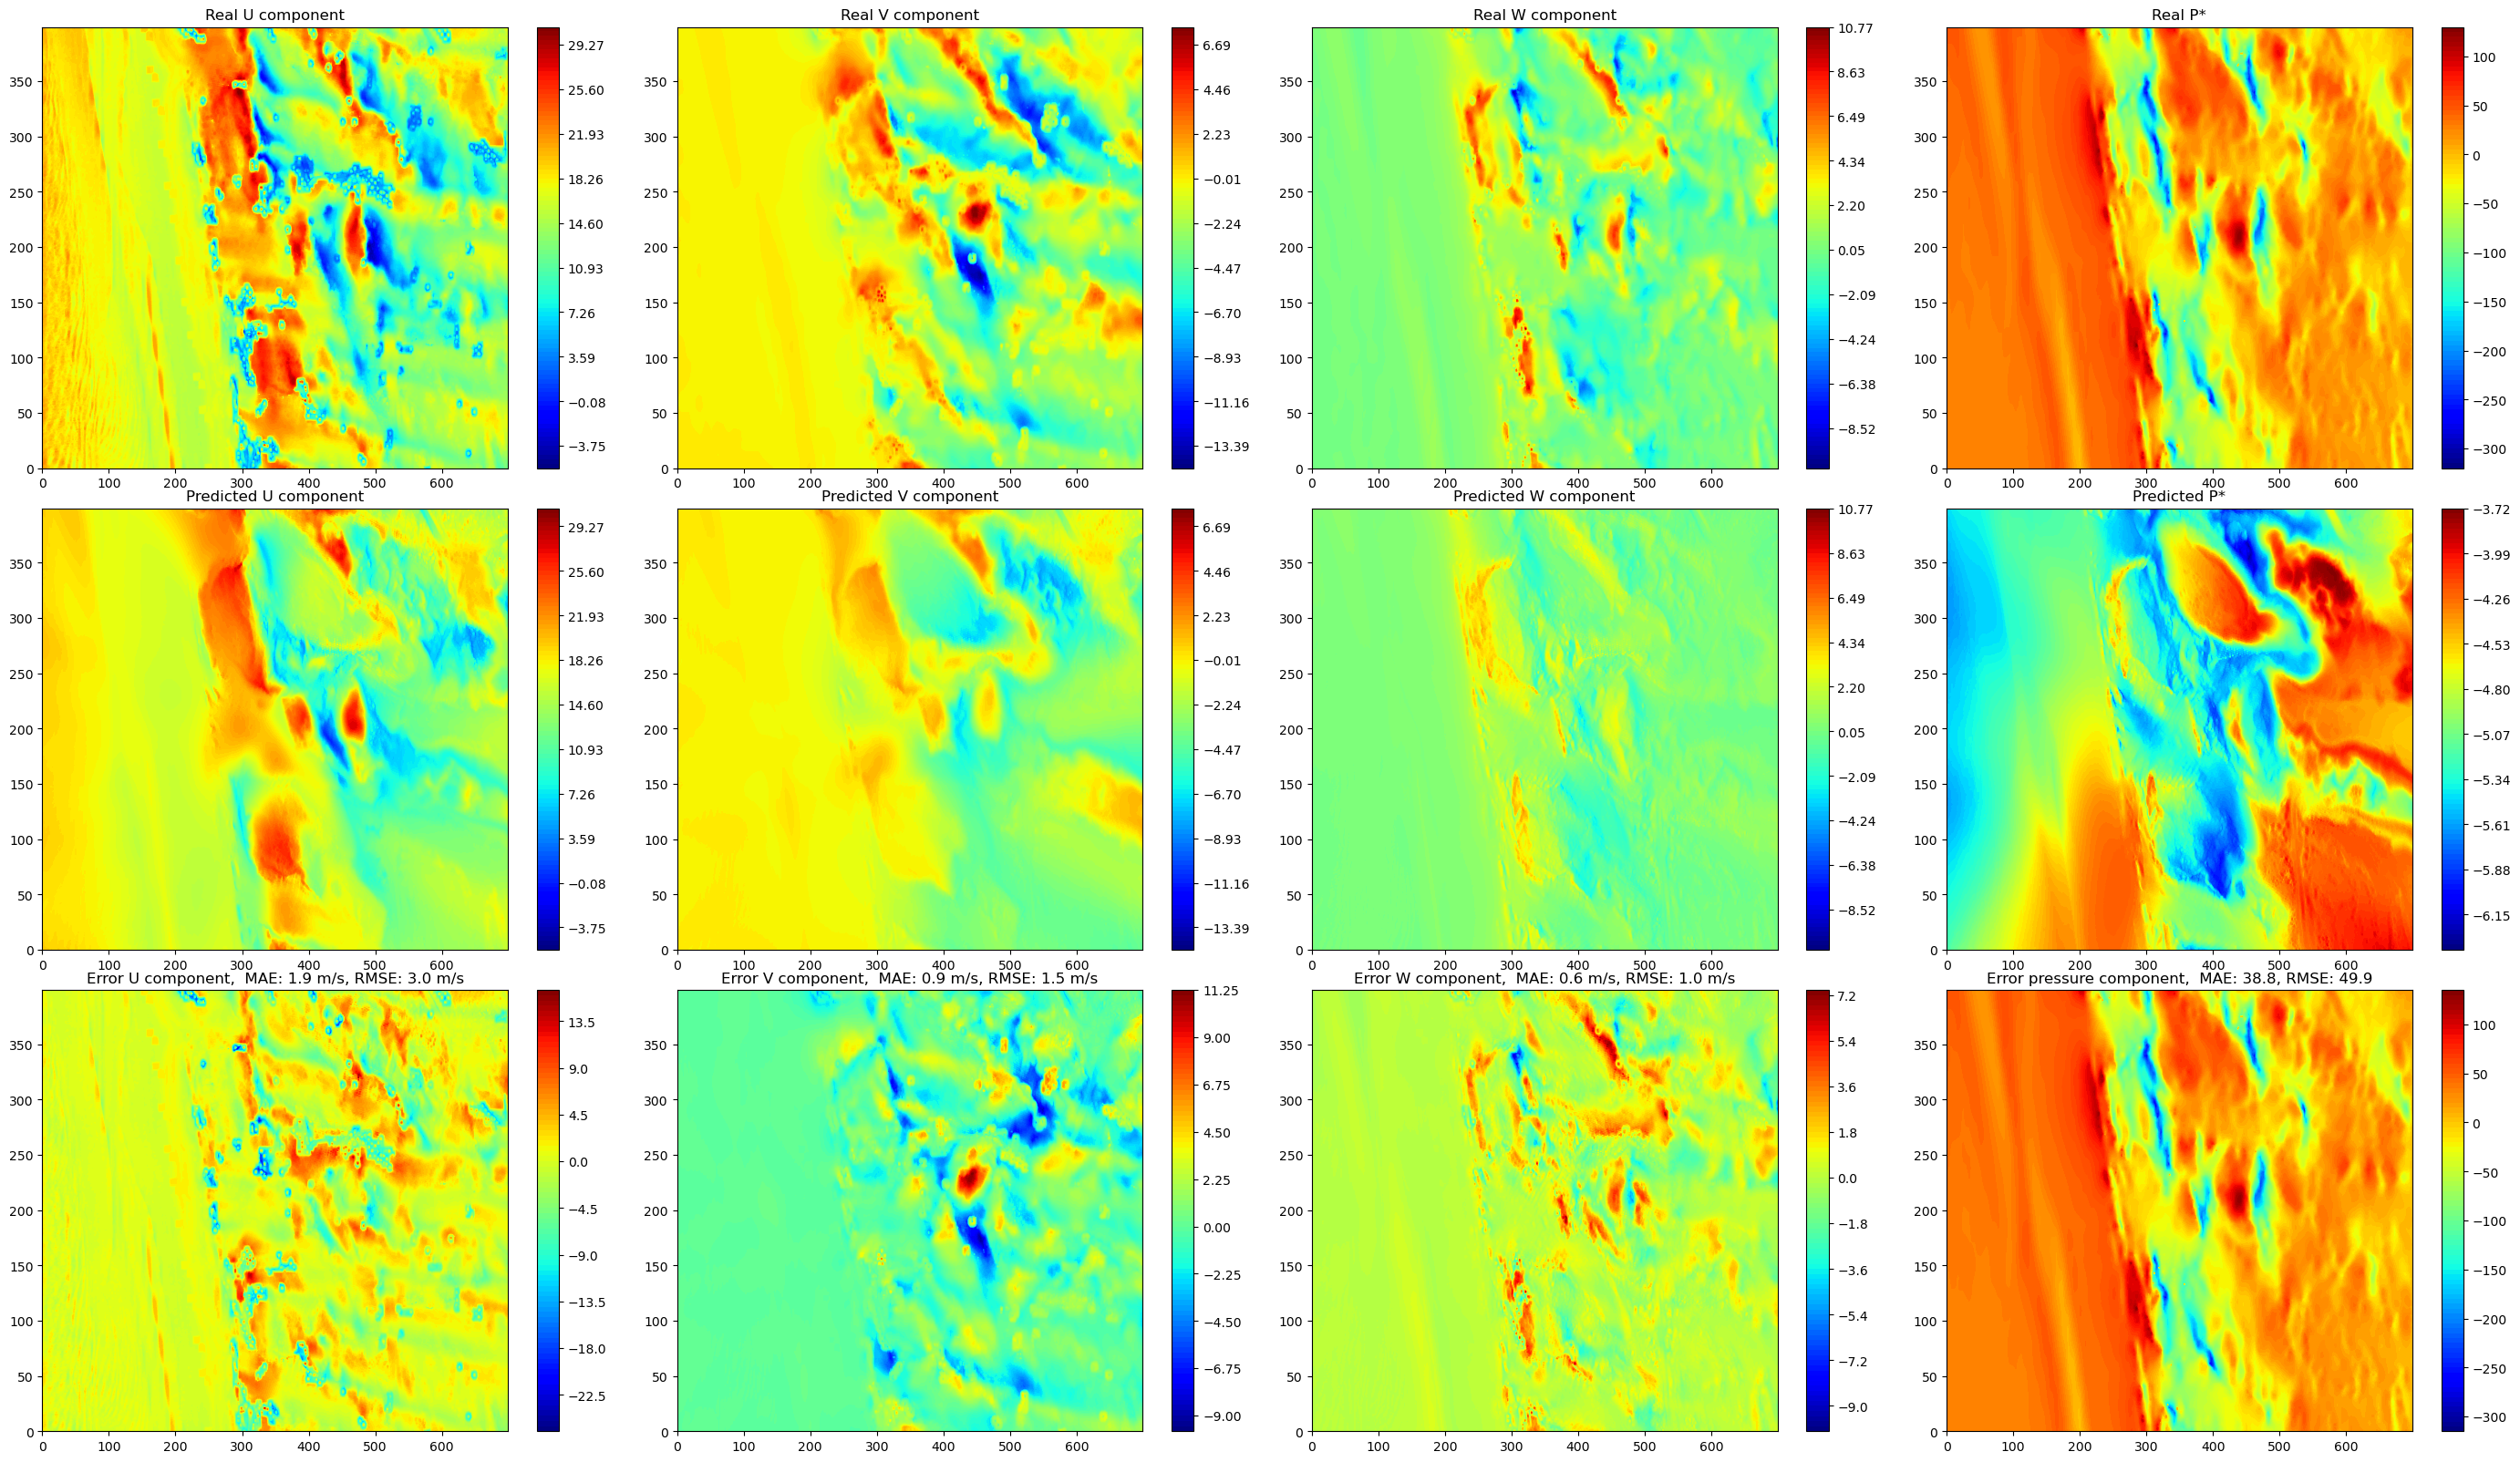

In [22]:
#get the preprocessed data and true U values
*preprocessed_data,  U_0, U_1, U_2, pressure, angle = get_preprocessed_data([7], get_pressure=True)
U_0, U_1, U_2, pressure = (i.reshape(shape) for i in (U_0, U_1, U_2, pressure))
u_pred, v_pred, w_pred, p_pred = PINN.predict(*preprocessed_data, shape=shape)

#From Saeb: P*=P/Rho + g*y, Rho = 1.293kg/m^3
#y = (preprocessed_data[2]-np.min(preprocessed_data[2])).reshape(shape)
#p_pred =-9.81*y + p_pred/1.293 #check to confirm is preprocessed_data[2] is verticle direction

u_levels = np.linspace(min(U_0.min(), u_pred.min()), max(U_0.max(), u_pred.max()), 100)
v_levels = np.linspace(min(U_1.min(), v_pred.min()), max(U_1.max(), v_pred.max()), 100)
w_levels = np.linspace(min(U_2.min(), w_pred.min()), max(U_2.max(), w_pred.max()), 100)
#p_levels = np.linspace(min(pressure.min(), p_pred.min()), max(pressure.max(), p_pred.max()), 100)

fig, axs = plt.subplots(3,4,  figsize=(28,16))#, sharex=True, sharey=True
fig.tight_layout()

## Truth Data
p1 = axs[0,0].contourf(U_0, levels=u_levels, cmap='jet')
fig.colorbar(p1, ax=axs[0,0])
axs[0,0].title.set_text('Real U component')

p2 = axs[0,1].contourf(U_1, levels=v_levels, cmap='jet')
fig.colorbar(p2, ax=axs[0,1])
axs[0,1].title.set_text('Real V component')

p3 = axs[0,2].contourf(U_2, levels=w_levels, cmap='jet')
fig.colorbar(p3, ax=axs[0,2])
axs[0,2].title.set_text('Real W component')

p4 = axs[0,3].contourf(pressure, levels=100, cmap='jet')
fig.colorbar(p4, ax=axs[0,3])
axs[0,3].title.set_text('Real P*')


## Prediction Data
p5 = axs[1,0].contourf(u_pred, levels=u_levels, cmap='jet')
fig.colorbar(p5, ax=axs[1,0])
axs[1,0].title.set_text('Predicted U component')

p6 = axs[1,1].contourf(v_pred, levels=v_levels, cmap='jet')
fig.colorbar(p6, ax=axs[1,1])
axs[1,1].title.set_text('Predicted V component')

p7 = axs[1,2].contourf(w_pred, levels=w_levels, cmap='jet')
fig.colorbar(p7, ax=axs[1,2])
axs[1,2].title.set_text('Predicted W component')

p8 = axs[1,3].contourf(p_pred, levels=100, cmap='jet')
fig.colorbar(p8, ax=axs[1,3])
axs[1,3].title.set_text('Predicted P*')


## Error Data
U_error = U_0-u_pred
V_error = U_1-v_pred
W_error = U_2-w_pred
P_error = pressure-p_pred


u_err, v_err, w_err, p_err = np.mean(np.abs(U_error)), np.mean(np.abs(V_error)), np.mean(np.abs(W_error)), np.mean(np.abs(P_error))
u_rmse, v_rmse, w_rmse, p_rmse = np.sqrt(np.mean((U_error)**2)), np.sqrt(np.mean((V_error)**2)), np.sqrt(np.mean((W_error)**2)), np.sqrt(np.mean((P_error)**2))

p9 = axs[2,0].contourf(U_error, levels=100, cmap='jet')
fig.colorbar(p9, ax=axs[2,0])
axs[2,0].title.set_text('Error U component,  MAE: {:0.1f} m/s, RMSE: {:0.1f} m/s'.format(u_err, u_rmse))


p10 = axs[2,1].contourf(V_error, levels=100, cmap='jet')
fig.colorbar(p10, ax=axs[2,1])
axs[2,1].title.set_text('Error V component,  MAE: {:0.1f} m/s, RMSE: {:0.1f} m/s'.format(v_err, v_rmse))

p11 = axs[2,2].contourf(W_error, levels=100, cmap='jet')
fig.colorbar(p11, ax=axs[2,2])
axs[2,2].title.set_text('Error W component,  MAE: {:0.1f} m/s, RMSE: {:0.1f} m/s'.format(w_err, w_rmse))

p12 = axs[2,3].contourf(P_error, levels=100, cmap='jet')
fig.colorbar(p12, ax=axs[2,3])
axs[2,3].title.set_text('Error pressure component,  MAE: {:0.1f}, RMSE: {:0.1f}'.format(p_err, p_rmse))

'''
shape=(400, 700)
#PINN.load_training_data(*(i[::4] for i in get_preprocessed_data([7])))
#PINN.train(use_c=True, use_m=True, use_data=True, epochs=0)
#shape_4 = int(shape[0]/1), int(shape[1]/4)

##adding in Momentum Loss
mx = PINN.mx.reshape(shape_4).data.cpu()
p13 = axs[3,0].contourf(mx, levels=100, cmap='jet')
fig.colorbar(p13, ax=axs[3,0])
axs[3,0].title.set_text('M-X component Plot')

my = PINN.my.reshape(shape_4).data.cpu()
p14 = axs[3,1].contourf(my, levels=100, cmap='jet')
fig.colorbar(p14, ax=axs[3,1])
axs[3,1].title.set_text('M-Y component Plot')

mz = PINN.mz.reshape(shape_4).data.cpu()
p15 = axs[3,2].contourf(mz, levels=100, cmap='jet')
fig.colorbar(p15, ax=axs[3,2])
axs[3,2].title.set_text('M-Z component Plot')

##adding in C Loss
c = PINN.c.reshape(shape_4).data.cpu()
p16 = axs[3,3].contourf(c, levels=100, cmap='jet')
fig.colorbar(p16, ax=axs[3,3])
axs[3,3].title.set_text('C component Plot')
'''
#plt.savefig("pressure_plot.png", dpi=300)

<Figure size 640x480 with 0 Axes>